In [ ]:
!pip install pennylane pennylane-cirq tensorflow matplotlib

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from tensorflow.keras.datasets import mnist
from sklearn.metrics import accuracy_score

#Load MNIST

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Keep only digits 0 and 1



In [ ]:
train_filter = np.where((y_train == 0) | (y_train == 1))
test_filter = np.where((y_test == 0) | (y_test == 1))

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

# Downsample using PCA to 4 dimensions for 4 qubits


In [ ]:
x_train = x_train.reshape((-1, 28*28)) / 255.0
x_test = x_test.reshape((-1, 28*28)) / 255.0

In [ ]:
pca = PCA(n_components=4)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

#Build QNN in Cirq

In [ ]:
import cirq

# Define 4 qubits

In [ ]:
qubits = [cirq.GridQubit(0, i) for i in range(4)]

# Encode classical data with Ry rotations


In [ ]:
def encode_data(x):
    return [cirq.ry(x[i])(qubits[i]) for i in range(4)]

# Parameterized layer


In [ ]:
def variational_layer(params):
    ops = []
    for i in range(4):
        ops.append(cirq.rz(params[i])(qubits[i]))
        ops.append(cirq.ry(params[i + 4])(qubits[i]))
    # Add entanglement
    for i in range(3):
        ops.append(cirq.CNOT(qubits[i], qubits[i+1]))
    return ops

# Full circuit


In [ ]:
def create_circuit(x, params):
    circuit = cirq.Circuit()
    circuit.append(encode_data(x))
    circuit.append(variational_layer(params))
    return circuit

#Define Expectation Measurement

In [ ]:
simulator = cirq.Simulator()

In [ ]:
def predict(x, params):
    circuit = create_circuit(x, params)
    circuit.append(cirq.measure(qubits[0], key='m'))
    result = simulator.run(circuit, repetitions=100)
    counts = result.histogram(key='m')
    prob_0 = counts.get(0, 0) / 100
    return prob_0  # closer to 1 = class 0

#Train with Manual Parameter Shift

In [ ]:
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-10
    return - (y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))


In [ ]:
def parameter_shift_grad(x, y, params, shift=np.pi/2):
    grads = np.zeros_like(params)
    for i in range(len(params)):
        plus = params.copy()
        minus = params.copy()
        plus[i] += shift
        minus[i] -= shift
        y_pred_plus = predict(x, plus)
        y_pred_minus = predict(x, minus)
        loss_plus = binary_cross_entropy(y, y_pred_plus)
        loss_minus = binary_cross_entropy(y, y_pred_minus)
        grads[i] = 0.5 * (loss_plus - loss_minus)
    return grads

#Training Loop (Small Subset)

In [ ]:
x_train_small = x_train[:100]
y_train_small = y_train[:100]
x_test_small = x_test[:100]
y_test_small = y_test[:100]

In [ ]:
params = np.random.uniform(0, 2*np.pi, size=8)
learning_rate = 0.1

In [ ]:
for epoch in range(25):
    total_loss = 0
    for x, y in zip(x_train_small, y_train_small):
        y_pred = predict(x, params)
        loss = binary_cross_entropy(y, y_pred)
        grads = parameter_shift_grad(x, y, params)
        params -= learning_rate * grads
        total_loss += loss
    print(f"Epoch {epoch+1}: Loss = {total_loss/len(x_train_small):.4f}")

Epoch 1: Loss = 0.6847
Epoch 2: Loss = 0.4810
Epoch 3: Loss = 1.1134
Epoch 4: Loss = 1.1437
Epoch 5: Loss = 0.9475
Epoch 6: Loss = 0.8955
Epoch 7: Loss = 0.7125
Epoch 8: Loss = 0.9891
Epoch 9: Loss = 0.9346
Epoch 10: Loss = 0.7479
Epoch 11: Loss = 0.7143
Epoch 12: Loss = 0.9518
Epoch 13: Loss = 0.7548
Epoch 14: Loss = 0.5874
Epoch 15: Loss = 1.3837
Epoch 16: Loss = 0.7563
Epoch 17: Loss = 0.7869
Epoch 18: Loss = 0.9083
Epoch 19: Loss = 0.9864
Epoch 20: Loss = 0.9727
Epoch 21: Loss = 0.7240
Epoch 22: Loss = 0.7542
Epoch 23: Loss = 0.7386
Epoch 24: Loss = 0.6452
Epoch 25: Loss = 0.7551


#Evaluate

In [ ]:
# correct = 0
# for x, y in zip(x_test[:100], y_test[:100]):
#     y_pred = predict(x, params)
#     predicted_label = 1 if y_pred < 0.5 else 0
#     correct += int(predicted_label == y)
# print(f"Accuracy: {correct} / 100 = {correct}%")


preds = [1 if predict(x, params) > 0.5 else 0 for x in x_test_small]
acc = accuracy_score(y_test_small, preds)
print(f"\nTest Accuracy: {acc * 100:.2f}%")



Test Accuracy: 75.00%


#USING QISKIT

In [ ]:
!pip install qiskit qiskit-aer scikit-learn matplotlib tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.5 MB/s eta 0:00:00


In [ ]:
!pip install qiskit-aer --upgrade

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Sampler
from concurrent.futures import ThreadPoolExecutor
import time

# Step 1: Load and preprocess MNIST data

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Filter digits 0 and 1

In [ ]:
train_filter = np.where((y_train == 0) | (y_train == 1))
test_filter = np.where((y_test == 0) | (y_test == 1))

In [ ]:
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

# Normalize and flatten

In [ ]:
x_train = x_train.reshape((-1, 28*28)) / 255.0
x_test = x_test.reshape((-1, 28*28)) / 255.0

# Reduce to 4 features for 4 qubits

In [ ]:
pca = PCA(n_components=4)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

# Scale data to [0, π] for better quantum encoding


In [ ]:
x_train = np.abs(x_train) * np.pi
x_test = np.abs(x_test) * np.pi

# Subset for quick testing

In [ ]:
x_train_small = x_train[:50]
y_train_small = y_train[:50]
x_test_small = x_test[:50]
y_test_small = y_test[:50]

# Step 2: Build variational quantum circuit with data and parameters


In [ ]:
def build_circuit(data_point, weights):
    """Build circuit for given data and weights"""
    qc = QuantumCircuit(4)
    qc.reset(range(4))

    # Encode data
    for i in range(4):
        qc.ry(data_point[i], i)

    # Parameterized layer
    for i in range(4):
        qc.rz(weights[i], i)
        qc.ry(weights[i+4], i)

    # Entangling layer
    for i in range(3):
        qc.cx(i, i+1)

    qc.measure_all()
    return qc

# Step 3: Inference using Qiskit's Sampler


In [ ]:
sampler = Sampler()

In [ ]:
def batch_predict(X, params, batch_size=10):
    """Predict in batches to reduce overhead"""
    predictions = []

    for i in range(0, len(X), batch_size):
        batch_X = X[i:i+batch_size]
        batch_circuits = []

        # Create circuits for the batch
        for x in batch_X:
            circuit = build_circuit(x, params)
            batch_circuits.append(circuit)

        # Run batch
        job = sampler.run(batch_circuits)
        results = job.result()

        # Process results
        for quasi_dist in results.quasi_dists:
            prob_0 = sum(p for key, p in quasi_dist.items()
                        if format(key, '04b')[-1] == '0')
            predictions.append(prob_0)

    return np.array(predictions)

In [ ]:
def compute_gradients_efficient(X, y, params):
    """Compute gradients with minimal circuit executions"""
    grads = np.zeros_like(params)
    shift = np.pi / 2

    # Get baseline predictions
    baseline_preds = batch_predict(X, params, batch_size=len(X))
    baseline_loss = np.mean(binary_cross_entropy(y, baseline_preds))

    # Compute gradients using forward differences (half the circuit calls)
    for i in range(len(params)):
        params_shifted = params.copy()
        params_shifted[i] += shift

        shifted_preds = batch_predict(X, params_shifted, batch_size=len(X))
        shifted_loss = np.mean(binary_cross_entropy(y, shifted_preds))

        # Forward difference approximation
        grads[i] = (shifted_loss - baseline_loss) / shift

    return grads

# Binary cross-entropy loss


In [ ]:
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-10
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# Step 4: Train QNN

In [ ]:
print("Starting optimized training...")
params = np.random.uniform(0, 2 * np.pi, size=8)
lr = 0.1  # Slightly reduced learning rate

Starting optimized training...


In [ ]:
batch_size = 25  # Process half the data at once
n_epochs = 5

In [ ]:
for epoch in range(n_epochs):
    start_time = time.time()

    # Shuffle data
    indices = np.random.permutation(len(x_train_small))
    x_shuffled = x_train_small[indices]
    y_shuffled = y_train_small[indices]

    epoch_loss = 0
    n_batches = 0

    for i in range(0, len(x_train_small), batch_size):
        batch_x = x_shuffled[i:i+batch_size]
        batch_y = y_shuffled[i:i+batch_size]

        # Compute gradients for the batch
        grads = compute_gradients_efficient(batch_x, batch_y, params)

        # Update parameters
        params -= lr * grads

        # Compute loss for monitoring
        preds = batch_predict(batch_x, params, batch_size=len(batch_x))
        batch_loss = np.mean(binary_cross_entropy(batch_y, preds))
        epoch_loss += batch_loss
        n_batches += 1

    avg_loss = epoch_loss / n_batches
    epoch_time = time.time() - start_time

    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Time = {epoch_time:.1f}s")


Epoch 1: Loss = 1.5564, Time = 116.6s
Epoch 2: Loss = 1.1615, Time = 104.7s
Epoch 3: Loss = 1.1441, Time = 103.8s
Epoch 4: Loss = 1.1458, Time = 112.3s
Epoch 5: Loss = 1.1407, Time = 110.6s


# Step 5: Evaluate

In [ ]:
print("\nEvaluating model...")
test_preds = batch_predict(x_test_small, params, batch_size=10)
binary_preds = (test_preds > 0.5).astype(int)
acc = accuracy_score(y_test_small, binary_preds)
print(f"Test Accuracy: {acc * 100:.2f}%")



Evaluating model...
Test Accuracy: 60.00%


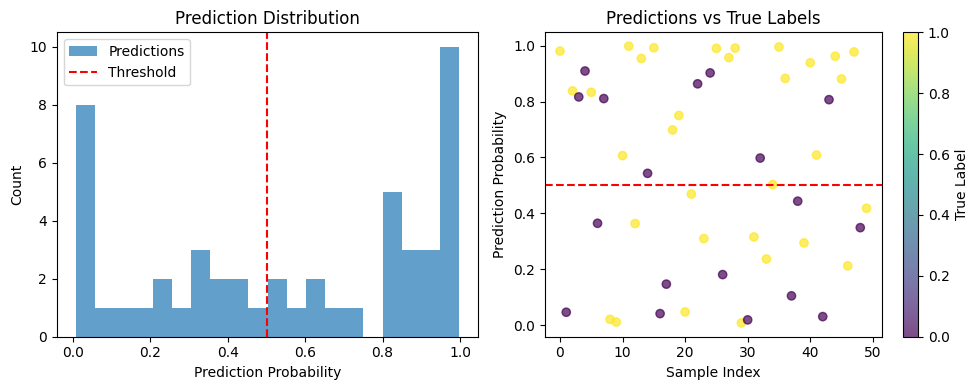


Optimization complete! Final parameters: [0.11665664 2.14340516 1.12396727 3.79378114 6.48265817 6.08922924
 4.05581539 4.91831713]


In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(test_preds, bins=20, alpha=0.7, label='Predictions')
plt.axvline(0.5, color='red', linestyle='--', label='Threshold')
plt.xlabel('Prediction Probability')
plt.ylabel('Count')
plt.title('Prediction Distribution')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test_small)), test_preds, c=y_test_small, cmap='viridis', alpha=0.7)
plt.axhline(0.5, color='red', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Prediction Probability')
plt.title('Predictions vs True Labels')
plt.colorbar(label='True Label')

plt.tight_layout()
plt.show()

print(f"\nOptimization complete! Final parameters: {params}")